적대적 신경망(GAN)

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

생성자(Generator)

In [2]:
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
# 128 : 임의의 노드 수(설정값)
# 7*7 : upsampling >> 14*14 >> 28*28
generator.add(BatchNormalization())
# 배치정규화 : input data 를 평균 0, 분산은 1이 되게 재배치
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D()) # 14*14 로 변환

generator.add(Conv2D(64, kernel_size=5, padding='same'))
# 5*5 filter(kernel) 사용 padding='same' : zero padding
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D()) # 28*28 로 변환

generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
# tanh : -1 ~ 1 사이로 출력

판별자(discriminator)

In [3]:
# feature extraction (특징 추출)

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28, 28, 1), padding='same'))
# strides : 2 >>
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))

discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False
# 판별자 자신이 학습이 되지 않게 학습 기능을 꺼줘 (매우 중요함!!!)

GAN NETWORK(생성자와 판별자 모델 연결)

In [4]:
ginput = Input(shape=(100,))
# 무작위로 100개 벡터값 집어 넣음

dis_output = discriminator(generator(ginput))
# 생성된 28*28 이미지 >> 판별자의 입력값으로 들어감

gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
# 참, 거짓 분류
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1078146 (4.11 MB)
Trainable params: 852609 (3.25 MB)
Non-trainable params: 225537 (881.00 KB)
_________________________________________________________________


1/1 [==============================] - 0s 16ms/step
epoch: 0 d_loss: 0.5248128771781921 g_loss: 0.27042442560195923
1/1 [==============================] - 0s 16ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'gan_images/gan_mnist_0.png'

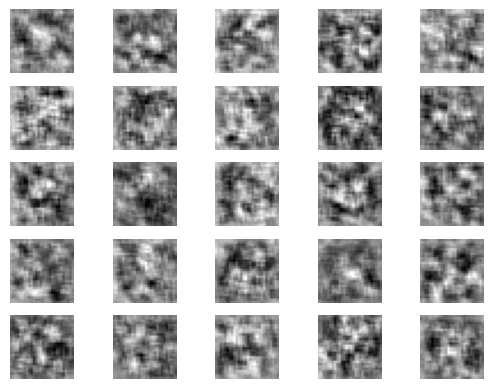

In [6]:
def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_, _) = mnist.load_data()
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    x_train = (x_train - 127.5) / 127.5

    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for i in range(epoch):
      idx = np.random.randint(0, x_train.shape[0], batch_size)
      imgs = x_train[idx]
      d_loss_real = discriminator.train_on_batch(imgs, true)

      noise = np.random.normal(0, 1, (batch_size, 100))
      gen_imgs = generator.predict(noise)
      d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      g_loss = gan.train_on_batch(noise, true)

      print('epoch:', i, 'd_loss:', d_loss, 'g_loss:', g_loss)

      if i % saving_interval == 0:
        noise = np.random.normal(0, 1, (25, 100))
        gen_imgs = generator.predict(noise)

        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5)
        count = 0

        for j in range(5):
          for k in range(5):
            axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
            axs[j, k].axis('off')
            count += 1
        fig.savefig('gan_images/gan_mnist_%d.png' % i)

gan_train(2001, 32, 200)